<a href="https://colab.research.google.com/github/saja30/adult_repository/blob/main/Project_4_Part_2_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
set_config(transform_output="pandas")


In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [8]:
file_name=("/content/drive/MyDrive/assignment/dult.csv")
df=pd.read_csv(file_name)
df.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [10]:
cat_df=df.select_dtypes("object").columns
cat_df

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'income'],
      dtype='object')

In [11]:
for col in cat_df:
  print(f"{col}: {df[col].value_counts()}")

workclass: workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
education: education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64
marital-status: marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64
occupation: occupation
Prof-specialty       61

In [12]:
# replacing ? with NA
df=df.replace("?",np.nan)

In [13]:
df["income"]=df["income"].replace({">50K":1,"<=50K":0})


In [14]:
df["income"].value_counts()

,count
income,
0,37155
1,11687


In [15]:
df.isna().sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2809
relationship,0
race,0
gender,0


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax
  def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
   gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

# exploratory visualization

<ipython-input-16-93cf1f2b69b1>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


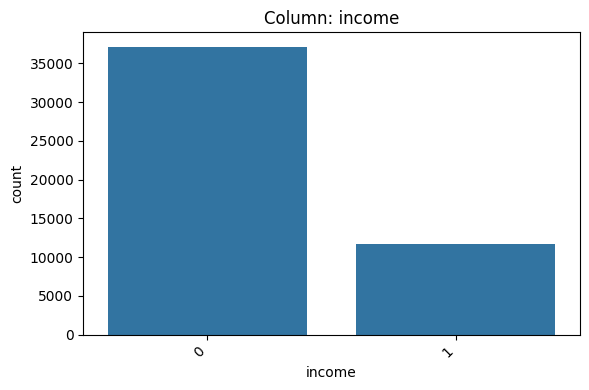

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 37155 times (76.07%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: income'}, xlabel='income', ylabel='count'>)

In [18]:
explore_categorical(df,"income")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. gender'}, xlabel='income', ylabel='Percent'>)

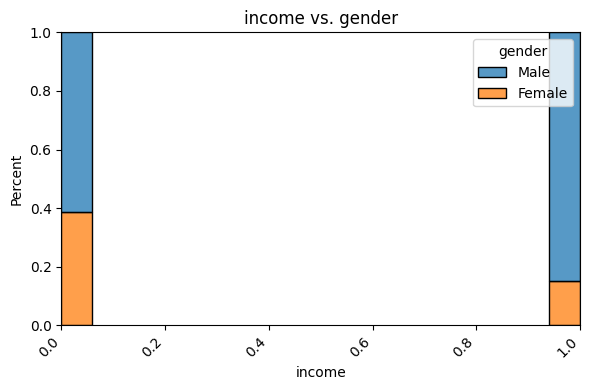

In [19]:
plot_categorical_vs_target(df,"income","gender",target_type="class")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'race vs. income'}, xlabel='race', ylabel='Percent'>)

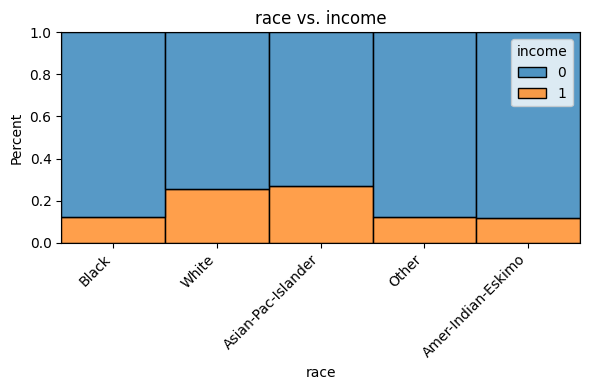

In [20]:
plot_categorical_vs_target(df,"race","income",target_type="class")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'marital-status vs. income'}, xlabel='marital-status', ylabel='Percent'>)

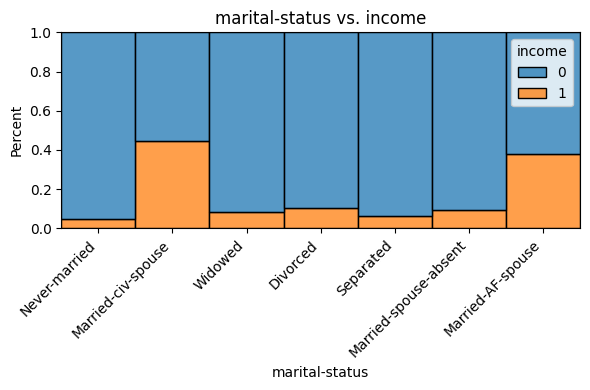

In [21]:
plot_categorical_vs_target(df,"marital-status","income",target_type="class")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. age'}, xlabel='income', ylabel='age'>)

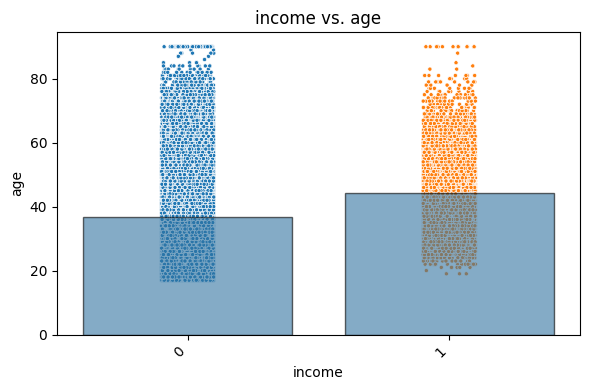

In [22]:
plot_categorical_vs_target(df,"income", y='age')

In [23]:
y=df["income"]
X=df.drop("income",axis=1)

In [24]:
# instantiate model validation
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [25]:
# greate object columns & processing
num_cols=X_train.select_dtypes("number").columns
num_scale=StandardScaler()
num_pipe=make_pipeline(num_scale)
num_tuple=("numeric",num_pipe,num_cols)


In [26]:
cat_cols=X_train.select_dtypes("object").columns
impute_na=SimpleImputer(strategy="constant",fill_value="NA")
cat_ohe=OneHotEncoder(drop="first",sparse=False)
cat_pipe=make_pipeline(impute_na,cat_ohe)
cat_tuple=("categorical",cat_pipe,cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder', OneHotEncoder(drop='first', sparse=False))]),
 Index(['workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'gender', 'native-country'],
       dtype='object'))

In [27]:
preprocessor=ColumnTransformer([num_tuple,cat_tuple],verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [28]:
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [29]:
X_train_tra=preprocessor.transform(X_train)
X_test_tra=preprocessor.transform(X_test)

In [30]:
X_train_tra.head(2)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_NA,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
27859,0.171771,-1.538807,0.358689,-0.144508,5.711885,-2.288453,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5654,0.026057,1.225138,1.136866,-0.144508,-0.220251,-0.276184,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_pur1=pd.concat([X_train_tra,y_train],axis=1)
df_pur1=pd.concat([X_test_tra,y_test],axis=1)
df_pu=pd.concat([df_pur1,df_pur1],axis=0)
df_pu.head(2)


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_NA,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
7762,1.264622,-1.482669,-0.419488,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
23881,-0.993938,-0.727612,-0.419488,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [32]:
# check fo target balance
y.value_counts(1)

,proportion
income,
0,0.760718
1,0.239282


In [33]:
# using SMOTE to make data Balanced
from imblearn.over_sampling import SMOTE


In [34]:
smote=SMOTE(random_state=42)
X_train_sm,y_train_sm=smote.fit_resample(X_train_tra,y_train)

In [35]:
y_train_sm.value_counts()

,count
income,
1,27801
0,27801


In [36]:
# choose a model
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train_sm,y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27801
           1       1.00      1.00      1.00     27801

    accuracy                           1.00     55602
   macro avg       1.00      1.00      1.00     55602
weighted avg       1.00      1.00      1.00     55602



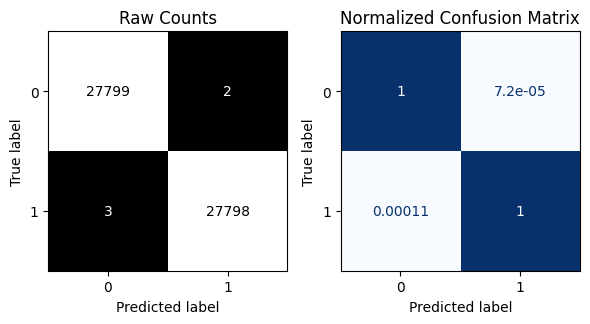


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      9354
           1       0.67      0.71      0.69      2857

    accuracy                           0.85     12211
   macro avg       0.79      0.80      0.80     12211
weighted avg       0.85      0.85      0.85     12211



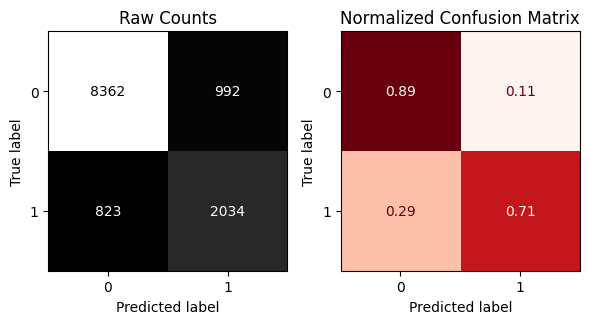

In [37]:
# evaluate default model
evaluate_classification(rf,X_train_sm,y_train_sm,X_test_tra,y_test)

# ther is overfit obviously in our data with accuracy=.85 for testing data & accuracr=1 for training data

In [38]:
# calculate permutation importance
from sklearn.inspection import permutation_importance
r=permutation_importance(rf,X_test_tra,y_test,n_repeats=5,random_state=42)

In [39]:
permutation_importance_series=pd.Series(r["importances_mean"],index=X_test_tra.columns.sort_values(ascending=False),
                                 name="Permutation Importance")
permutation_importance_series

,Permutation Importance
workclass_Without-pay,0.014888
workclass_State-gov,0.003489
workclass_Self-emp-not-inc,0.008713
workclass_Self-emp-inc,0.036361
workclass_Private,0.006568
workclass_Never-worked,0.005634
workclass_NA,-0.001130
workclass_Local-gov,0.000213
relationship_Wife,0.000000
relationship_Unmarried,0.000213


[Text(0.5, 1.0, 'Permutation Importance'),
 Text(0.5, 0, 'Importance'),
 Text(0, 0.5, 'Feature')]

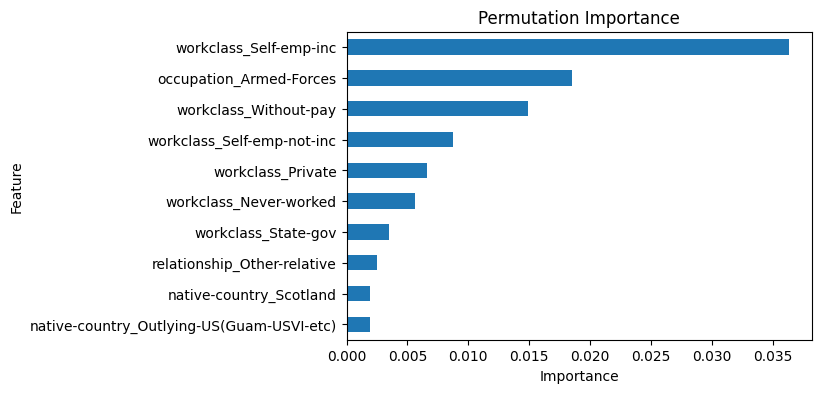

In [40]:
ax=permutation_importance_series.sort_values().tail(10).plot(kind="barh",figsize=(6,4))
ax.set(title="Permutation Importance",xlabel="Importance",ylabel="Feature")

# Create Explanatory Visualizations for the most important feature

In [41]:
# greate df to make visualization
plot_train=pd.concat([X_train_sm,y_train_sm],axis=1)
plot_test=pd.concat([X_test_tra,y_test],axis=1)
plot_df=pd.concat([plot_train,plot_test])
pd.set_option('display.max_columns',100)


In [42]:
plot_df.head(2)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_NA,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_NA,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_NA,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.171771,-1.538807,0.358689,-0.144508,5.711885,-2.288453,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.026057,1.225138,1.136866,-0.144508,-0.220251,-0.276184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'workclass_Self-emp-inc vs. income'}, xlabel='workclass_Self-emp-inc', ylabel='Percent'>)

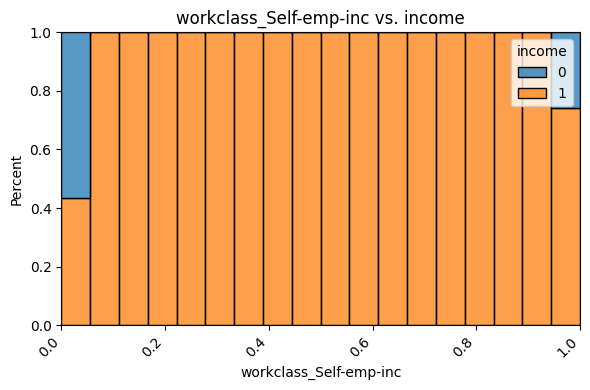

In [44]:
plot_categorical_vs_target(plot_df,"workclass_Self-emp-inc","income",target_type='class')

# we observe adults whome tend to be in  workclass_self_emp_inc had income>=50K more than other workclasses

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'occupation_Armed-Forces vs. income'}, xlabel='occupation_Armed-Forces', ylabel='Percent'>)

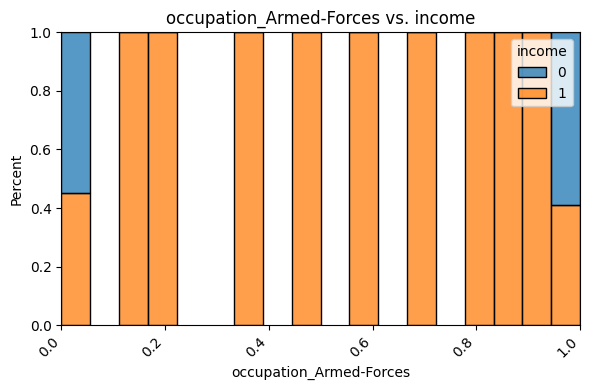

In [45]:
plot_categorical_vs_target(plot_df,"occupation_Armed-Forces","income",target_type='class')

# i see there is no differences in income according to occupation type

---



---



***                Second section     ***

In [46]:
# Apply PCA to get 3 principal components
from sklearn.decomposition import PCA
pca_3=PCA(n_components=3)
pca_3.fit(X_train_sm)

PCA(n_components=3)

In [47]:
pca_3_train=pca_3.transform(X_train_sm)
pca_3_test=pca_3.transform(X_test_tra)
pca_3_train.head(2)

,pca0,pca1,pca2
0,-0.649178,4.381575,3.430792
1,-0.085266,-0.014087,-0.469786


In [48]:
# concat pca_3 with orginal data
pca_df_train=pd.concat([pca_3_train,X_train_sm],axis=1)
pca_df_test=pd.concat([pca_3_test,X_test_tra],axis=1)
pca_df=pd.concat([pca_df_train,pca_df_test])
pca_df.head(2)


,pca0,pca1,pca2,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_NA,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_NA,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_NA,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.649178,4.381575,3.430792,0.171771,-1.538807,0.358689,-0.144508,5.711885,-2.288453,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.085266,-0.014087,-0.469786,0.026057,1.225138,1.136866,-0.144508,-0.220251,-0.276184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# # choose a model to fit X_train_tra with pca columns
rf_pca=RandomForestClassifier(random_state=42)
rf_pca.fit(pca_df_train,y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27801
           1       1.00      1.00      1.00     27801

    accuracy                           1.00     55602
   macro avg       1.00      1.00      1.00     55602
weighted avg       1.00      1.00      1.00     55602



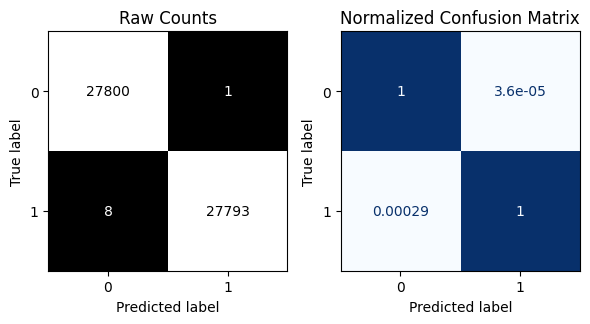


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      9354
           1       0.52      0.80      0.63      2857

    accuracy                           0.78     12211
   macro avg       0.73      0.79      0.74     12211
weighted avg       0.83      0.78      0.80     12211



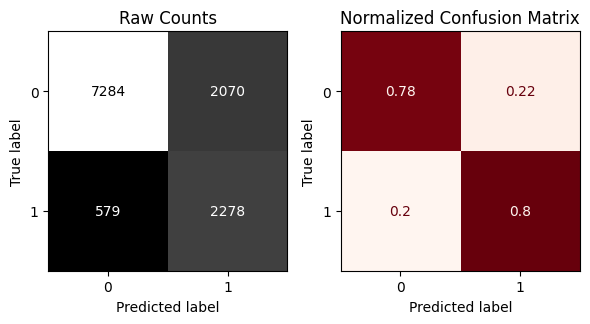

In [50]:
evaluate_classification(rf_pca,pca_df_train,y_train_sm,pca_3_test,y_test)

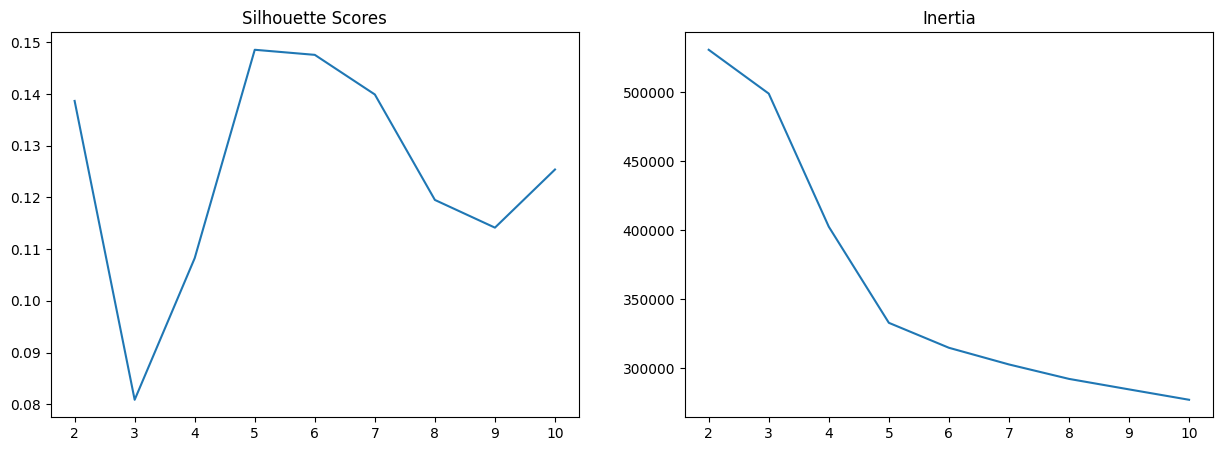

In [79]:
# Apply clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_train_sm)
  sils.append(silhouette_score(X_train_sm, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [80]:
# using appropriate number of clusters
from sklearn.cluster import KMeans
kmeans_approp=KMeans(n_clusters=5,random_state=42,n_init="auto")
kmeans_approp.fit(X_train_sm)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [81]:
k_x_trian=kmeans_approp.labels_
k_x_test=kmeans_approp.predict(X_test_tra)

In [82]:
#concat clusters with orginal features
k_train=pd.concat([X_train_sm,pd.Series(k_x_trian,name="cluster")],axis=1)
k_test=pd.concat([X_test_tra,pd.Series(k_x_test,name="cluster")],axis=1)
k_df=pd.concat([k_train,k_test],axis=0)
k_df.head(2)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_NA,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_NA,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_NA,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,cluster
0,0.171771,-1.538807,0.358689,-0.144508,5.711885,-2.288453,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
1,0.026057,1.225138,1.136866,-0.144508,-0.220251,-0.276184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
rf_kmean=RandomForestClassifier(random_state=42)
rf_kmean.fit(k_train,y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27801
           1       1.00      1.00      1.00     27801

    accuracy                           1.00     55602
   macro avg       1.00      1.00      1.00     55602
weighted avg       1.00      1.00      1.00     55602



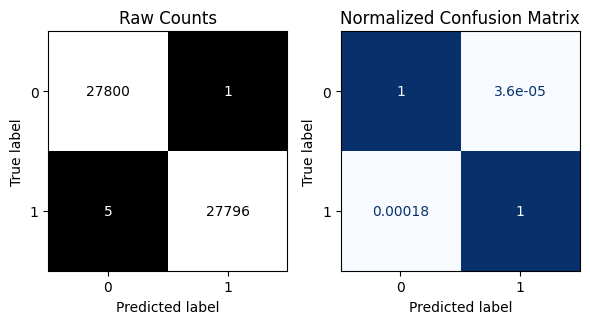

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [84]:
evaluate_classification(rf_kmean,k_train,y_train_sm,k_test,y_test)

#                           feature selection

In [58]:
# using wrapper method
#instantiate the model
dt=DecisionTreeClassifier(random_state=42)

In [59]:
from sklearn.feature_selection import SequentialFeatureSelector
sk_sfs=SequentialFeatureSelector(dt,n_features_to_select=10,direction="forward",cv=2,n_jobs=-1)
sk_sfs.fit(pca_df_train,y_train_sm)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=10, n_jobs=-1)

In [60]:
features_to_keep=sk_sfs.support_
features_to_keep

array([False, False, False, False, False,  True,  True,  True, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [61]:
x_train_10=pca_df_train.loc[:,features_to_keep]
x_test_10=pca_df_test.loc[:,features_to_keep]
x_train_10.head(2)

,educational-num,capital-gain,capital-loss,workclass_NA,workclass_Self-emp-not-inc,marital-status_Married-civ-spouse,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Other-service,race_White
0,0.358689,-0.144508,5.711885,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.136866,-0.144508,-0.220251,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [62]:
x_train_10.shape


(55602, 10)

In [72]:
# model for feature selection
rf_sfs=RandomForestClassifier(random_state=42)
rf_sfs.fit(x_train_10,y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     27801
           1       0.83      0.89      0.86     27801

    accuracy                           0.86     55602
   macro avg       0.86      0.86      0.86     55602
weighted avg       0.86      0.86      0.86     55602



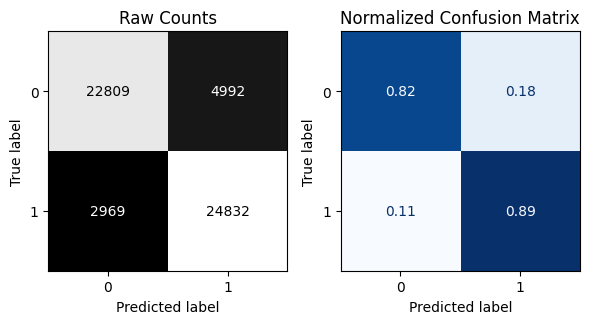


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      9354
           1       0.59      0.84      0.69      2857

    accuracy                           0.83     12211
   macro avg       0.77      0.83      0.79     12211
weighted avg       0.86      0.83      0.84     12211



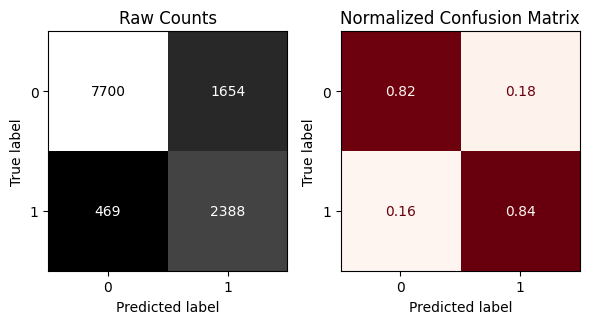

In [73]:
evaluate_classification(rf_sfs,x_train_10,y_train_sm,x_test_10,y_test)

In [74]:
# Extract and visualize the top 10 features
r=permutation_importance(rf_sfs,x_test_10,y_test,n_repeats=5,random_state=42)

In [75]:
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [76]:
permutation_importance=pd.Series(r["importances_mean"],index=x_test_10.columns,
                                 name="Permutation Importance")
permutation_importance

,Permutation Importance
educational-num,0.034919
capital-gain,0.045418
capital-loss,0.011367
workclass_NA,0.003014
workclass_Self-emp-not-inc,0.005143
marital-status_Married-civ-spouse,0.128818
occupation_Farming-fishing,0.002522
occupation_Handlers-cleaners,0.005765
occupation_Other-service,0.005389
race_White,0.002522


[Text(0.5, 1.0, 'Permutation Importance'),
 Text(0.5, 0, 'Importance'),
 Text(0, 0.5, 'Feature')]

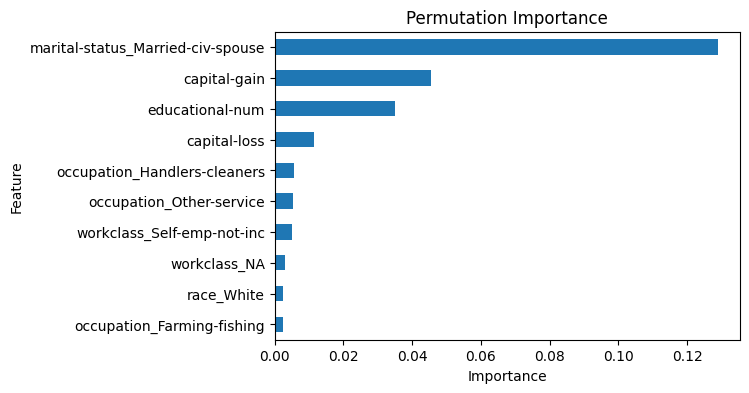

In [77]:
ax=permutation_importance.sort_values().tail(10).plot(kind="barh",figsize=(6,4))
ax.set(title="Permutation Importance",xlabel="Importance",ylabel="Feature")

# Tere are differenr between these features compare to the model from Part 1.
the model in part 1 the features importances(5) arranged as
1. workclass_self_emp_inc
2. occupation_armed_forces
3. workclass_witrhout_pay
4. workclass_self_emp_not_inc
5. workclass_private


# while after appling engineering featutres with pca
the model in part 2  the features importances(5) arranged as
1. marital-status_Married-civ-spouse
2. capital_gain
3. educational_num
4. capital|_loss
5. occupation_Handlers-cleaners






